In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator

In [3]:
src_path_train = "out_faces"
src_path_test = "test_set_a"
src_path_anomaly = "anomaly_test"

train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        # rotation_range=20,
        # zoom_range=0.05,
        # width_shift_range=0.05,
        # height_shift_range=0.05,
        # shear_range=0.05,
        # horizontal_flip=True,
        # fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [4]:
batch_size = 8
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(100, 100),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='input',
    subset='training',
    shuffle=True,
    seed=42
)
valid_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(100, 100),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='input',
    subset='validation',
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory=src_path_test,
    target_size=(100, 100),
    color_mode="grayscale",
    batch_size=1,
    class_mode='input',
    shuffle=False,
    seed=42
)

anomaly_test_generator = test_datagen.flow_from_directory(
    directory=src_path_anomaly,
    target_size=(100, 100),
    color_mode="grayscale",
    batch_size=1,
    class_mode='input',
    shuffle=False,
    seed=42
)

Found 386 images belonging to 1 classes.
Found 96 images belonging to 1 classes.
Found 17 images belonging to 1 classes.
Found 17 images belonging to 1 classes.


In [5]:
input = layers.Input(shape=(100, 100, 1))

# Encoder
e = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
e = layers.MaxPooling2D((2, 2), padding="same")(e)
# x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
# x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
# x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
d = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(e)
d = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(d)

# Autoencoder
autoencoder = Model(input, d)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

model_encoder = Model(input, e)

# # ENCODER
# input_img = layers.Input(shape=(100, 100, 1))
# encode1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
# encode2 = layers.MaxPooling2D((2, 2), padding='same')(encode1)
# l = layers.Flatten()(encode2)
# encoder_output = layers.Dense(100, activation='linear')(l)

# # DECODER
# d = layers.Dense(1024, activation='linear')(encoder_output) 
# d = layers.Reshape((32,32,1))(d)
# decode3 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(d) 
# decode4 = layers.UpSampling2D((2, 2))(decode3)

# model_encoder = Model(input_img, encoder_output)
# model = Model(input_img, decode4)
# model.compile(optimizer="adam", loss="mse")

# model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 100, 100, 64)     36928     
 nspose)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 1)       577       
                                                                 
Total params: 38,145
Trainable params: 38,145
Non-trainable p

In [6]:
history = autoencoder.fit(train_generator,
                    validation_data = train_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=60, verbose=1)

Epoch 1/60
48/48 [==============================] - 20s 60ms/step - loss: 0.0214 - val_loss: 0.0037
Epoch 2/60
48/48 [==============================] - 1s 18ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 3/60
48/48 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 4/60
48/48 [==============================] - 1s 17ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/60
48/48 [==============================] - 1s 16ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/60
48/48 [==============================] - 1s 16ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/60
48/48 [==============================] - 1s 16ms/step - loss: 9.5423e-04 - val_loss: 9.1090e-04
Epoch 8/60
48/48 [==============================] - 1s 17ms/step - loss: 8.7767e-04 - val_loss: 8.3447e-04
Epoch 9/60
48/48 [==============================] - 1s 20ms/step - loss: 8.1839e-04 - val_loss: 7.7947e-04
Epoch 10/60
48/48 [==============================] - 1s 17ms/step - loss: 7.5771e-04

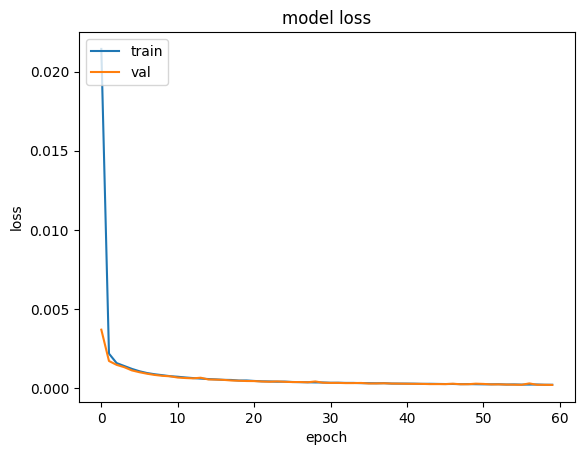

In [7]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:
autoencoder.evaluate(anomaly_test_generator)

17/17 [==============================] - 0s 7ms/step - loss: 2.0156e-04


0.00020155607489868999

In [9]:
autoencoder.evaluate(test_generator)

17/17 [==============================] - 0s 6ms/step - loss: 1.9540e-04


0.0001953955797944218

In [60]:
model = Sequential()
model.add(model_encoder)
model.add(Flatten())
model.add(Dense(units=64, activation='linear'))
# model.add(Dropout(0.5))
# model.add(Dense(units=64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(units=64, activation='linear'))

In [61]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 50, 50, 64)        640       
                                                                 
 flatten_6 (Flatten)         (None, 160000)            0         
                                                                 
 dense_16 (Dense)            (None, 64)                10240064  
                                                                 
Total params: 10,240,704
Trainable params: 10,240,704
Non-trainable params: 0
_________________________________________________________________


In [62]:
# out_arr = autoencoder.predict(anomaly_test_generator)
out_arr_1 = model.predict(test_generator)
out_arr_2 = model.predict(anomaly_test_generator)

17/17 [==============================] - 0s 3ms/step


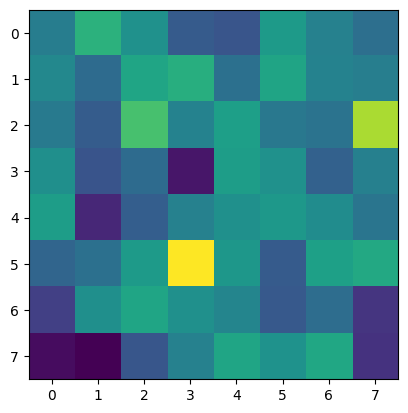

In [65]:
plt.imshow(out_arr_1[0].reshape((8,8)))

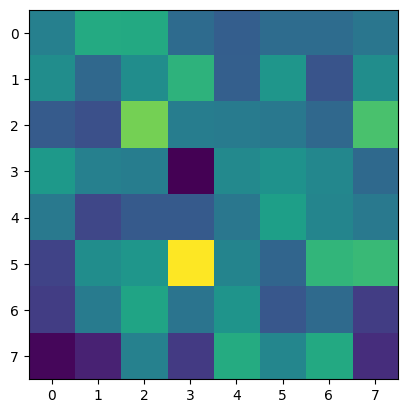

In [66]:
plt.imshow(out_arr_2[0].reshape((8,8)))

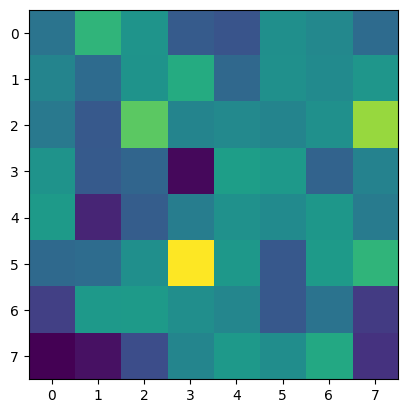

In [67]:
plt.imshow(out_arr_1[3].reshape((8,8)))

In [43]:
from skimage.metrics import structural_similarity

In [81]:
avg = 0
for i in range(len(out_arr_1)):
    (score, diff) = structural_similarity(out_arr_1[i].reshape((8,8)), out_arr_1[5].reshape((8,8)), full=True)
    print("Image similarity", score)
    avg = avg + score
print("\n", avg/len(out_arr_1))

Image similarity 0.9740149825811386
Image similarity 0.9949075430631638
Image similarity 0.9836607277393341
Image similarity 0.9803892374038696
Image similarity 0.992521271109581
Image similarity 1.0
Image similarity 0.9861661195755005
Image similarity 0.9996190369129181
Image similarity 0.9869229644536972
Image similarity 0.9785231798887253
Image similarity 0.9729500561952591
Image similarity 0.9711406081914902
Image similarity 0.9903357177972794
Image similarity 0.981996476650238
Image similarity 0.9816646873950958
Image similarity 0.9889619499444962
Image similarity 0.9943212121725082

 0.9857703394749585


In [82]:
avg = 0
for i in range(len(out_arr_1)):
    (score, diff) = structural_similarity(out_arr_2[i].reshape((8,8)), out_arr_1[5].reshape((8,8)), full=True)
    print("Image similarity", score)
    avg = avg + score
print("\n", avg/len(out_arr_1))

Image similarity 0.4027279280126095
Image similarity 0.4460940957069397
Image similarity 0.605927363038063
Image similarity 0.6395994871854782
Image similarity 0.6317580416798592
Image similarity 0.6258254051208496
Image similarity 0.6194453835487366
Image similarity 0.5942107513546944
Image similarity 0.5562343522906303
Image similarity 0.6043534874916077
Image similarity 0.625752829015255
Image similarity 0.6182826831936836
Image similarity 0.6082706302404404
Image similarity 0.6099814027547836
Image similarity 0.6246191933751106
Image similarity 0.6169254779815674
Image similarity 0.6761603057384491

 0.5944805186899269
